In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [2]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

INFO preprocessing: Creating document list from TXT files ...


['corpus_txt/Lovecraft_AttheMountainofMadness.txt',
 'corpus_txt/Howard_TheDevilinIron.txt',
 'corpus_txt/Poe_ThePurloinedLetter.txt',
 'corpus_txt/Lovecraft_TheShunnedHouse.txt',
 'corpus_txt/Poe_TheMasqueoftheRedDeath.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [3]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

INFO preprocessing: Creating document labels ...


['Lovecraft_AttheMountainofMadness',
 'Howard_TheDevilinIron',
 'Poe_ThePurloinedLetter',
 'Lovecraft_TheShunnedHouse',
 'Poe_TheMasqueoftheRedDeath']

#### Corpus laden

In [4]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [5]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

INFO preprocessing: Accessing TXT documents ...


#### Create Dictionaries

In [6]:
id_types = pre.create_dictionary(doc_tokens)
doc_ids = pre.create_dictionary(doc_labels)

#### Sparse BOW Model

In [7]:
sparse_bow = pre.create_sparse_bow(doc_labels, doc_tokens, id_types, doc_ids)

In [8]:
sparse_bow[:5]

0
doc_id token_id   
1      16384     1
       5         1
       6         1
       16394     1
       16396     1

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [9]:
pre.save_sparse_bow(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [10]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

INFO summa.preprocessing.cleaner: 'pattern' package not found; tag filters are not available for English


In [11]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


In [12]:
corpus = MmCorpus('gensim_txt.mm')

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


In [13]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [14]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "en.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [15]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

INFO preprocessing: Finding hapax legomena ...
INFO preprocessing: Finding stopwords ...
INFO preprocessing: Removing features ...


In [16]:
len(features_to_be_removed)

75

In [17]:
pre.save_sparse_bow(sparse_bow_short, "gensim_txt")

In [18]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 192053 non-zero entries


#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

In [19]:
doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [20]:
len(doc2bow_list)

17

In [21]:
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, passes = 10, iterations = 20)

INFO gensim.models.ldamodel: using symmetric alpha at 0.05
INFO gensim.models.ldamodel: using symmetric eta at 4.49781855799937e-05
INFO gensim.models.ldamodel: using serial LDA version on this node
INFO gensim.models.ldamodel: running online LDA training, 20 topics, 10 passes over the supplied corpus of 17 documents, updating model once every 17 documents, evaluating perplexity every 17 documents, iterating 20x with a convergence threshold of 0.001000
INFO gensim.models.ldamodel: -14.377 per-word bound, 21272.3 perplexity estimate based on a held-out corpus of 17 documents with 192053 words
INFO gensim.models.ldamodel: PROGRESS: pass 0, at document #17/17
INFO gensim.models.ldamodel: topic #6 (0.050): 0.004*"leaves-on" + 0.004*"descend" + 0.003*"panelling" + 0.003*"chills" + 0.003*"displace" + 0.003*"thoroughfare" + 0.003*"impotent" + 0.003*"david" + 0.003*"compact" + 0.003*"heya"
INFO gensim.models.ldamodel: topic #9 (0.050): 0.003*"displace" + 0.003*"compact" + 0.003*"distract" + 0.

In [22]:
model.get_document_topics(doc2bow_list[1])

[(1, 0.1749414196646584),
 (3, 0.14095760179830774),
 (6, 0.11539206269649878),
 (8, 0.10514351634510403),
 (13, 0.050179649687802842),
 (15, 0.052784741838118245),
 (16, 0.26134939196941909),
 (19, 0.098658323435042342)]

In [23]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['anticipating',
 'pantherish',
 'chap',
 'david',
 'smaller',
 'gipsies',
 'heya',
 'monotony',
 'descend',
 'displace']

In [24]:
#Topic probabilities - zum Testen der Funktion
topics = model.show_topics(num_topics = model.num_topics, formatted=False)
keywords = []

num_topics = model.num_topics
topics_df = pre.pd.DataFrame(index = range(num_topics), columns= range(10))

for topic, values in topics:
    keyword = [value[0] for value in values]
    topics_df.loc[topic] = keyword

topics_df

,0,1,2,3,4,5,6,7,8,9
0,displace,lend,chills,poorly-educated,stolen,pantherish,excess,descend,david,leaves-on
1,anticipating,pantherish,chap,david,smaller,gipsies,heya,monotony,descend,displace
2,faithfully,distract,descend,david,chills,displace,lee,anticipating,drat,gaudy
3,trick,chills,impotent,drat,clayey,poorly-educated,david,overthrew,whirl,distract
4,cleaning,gaudy,pays,compact,drat,impotent,whirl,poorly-educated,david,brythunian
5,david,heya,lee,poorly-educated,playground,descend,gaudy,trick,drat,impotent
6,panelling,trick,shooed,gaudy,distract,tempest,lend,gentes,ability,thoroughfare
7,displace,impotent,perspectivischen,other,poorly-educated,lend,descend,donna,monotony,compact
8,brythunian,observation,leaves-on,cleaning,dimmed,pays,mantelpiece,poorly-educated,life-force,go-see
9,displace,compact,distract,descend,heya,lee,monotony,faithfully,chills,playground


In [25]:
topics_df = pre.gensim2dataframe(model)
topics_df

,0,1,2,3,4,5,6,7,8,9
0,displace,lend,chills,poorly-educated,stolen,pantherish,excess,descend,david,leaves-on
1,anticipating,pantherish,chap,david,smaller,gipsies,heya,monotony,descend,displace
2,faithfully,distract,descend,david,chills,displace,lee,anticipating,drat,gaudy
3,trick,chills,impotent,drat,clayey,poorly-educated,david,overthrew,whirl,distract
4,cleaning,gaudy,pays,compact,drat,impotent,whirl,poorly-educated,david,brythunian
5,david,heya,lee,poorly-educated,playground,descend,gaudy,trick,drat,impotent
6,panelling,trick,shooed,gaudy,distract,tempest,lend,gentes,ability,thoroughfare
7,displace,impotent,perspectivischen,other,poorly-educated,lend,descend,donna,monotony,compact
8,brythunian,observation,leaves-on,cleaning,dimmed,pays,mantelpiece,poorly-educated,life-force,go-see
9,displace,compact,distract,descend,heya,lee,monotony,faithfully,chills,playground


In [26]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,displace,anticipating,faithfully,trick,cleaning,david,panelling,displace,brythunian,displace,futility,panelling,trick,ridiculous,whirl,sextant,saul,anticipating,descend,anticipating
1,lend,pantherish,distract,chills,gaudy,heya,trick,impotent,observation,compact,afternoons,trick,lee,blots,leaves-on,prided,whirl,heya,lee,excess
2,chills,chap,descend,impotent,pays,lee,shooed,perspectivischen,leaves-on,distract,rosse,faithfully,descend,distributio,displace,descend,gardens,uninterruptedly,david,david
3,poorly-educated,david,david,drat,compact,poorly-educated,gaudy,other,cleaning,descend,quickness,skinning,anticipating,uncooked,poorly-educated,sifted,displace,descend,whirl,wherever
4,stolen,smaller,chills,clayey,drat,playground,distract,poorly-educated,dimmed,heya,orpheus,distract,distract,playground,ground-moles,lighters,leaves-on,trick,gaudy,roped
5,pantherish,gipsies,displace,poorly-educated,impotent,descend,tempest,lend,pays,lee,fisherman,playground,pays,fewer,drat,cameos,heya,stolen,heya,rejoice
6,excess,heya,lee,david,whirl,gaudy,lend,descend,mantelpiece,monotony,providence-built,poorly-educated,gaudy,faithfully,monotony,donna,satrap's,poorly-educated,smaller,feet
7,descend,monotony,anticipating,overthrew,poorly-educated,trick,gentes,donna,poorly-educated,faithfully,rubbed,descend,panelling,trick,cleaning,anticipating,poorly-educated,thoroughfare,faithfully,lend
8,david,descend,drat,whirl,david,drat,ability,monotony,life-force,chills,stones,gaudy,playground,lend,descend,holmes,ground-moles,playground,distract,captor
9,leaves-on,displace,gaudy,distract,brythunian,impotent,thoroughfare,compact,go-see,playground,shoutings,shooed,leaves-on,hummil's,impotent,heya,fashionable,testifying,go-see,pondicherry


## Visualisierung 

In [27]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [28]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

<module 'matplotlib.pyplot' from '/home/sina/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

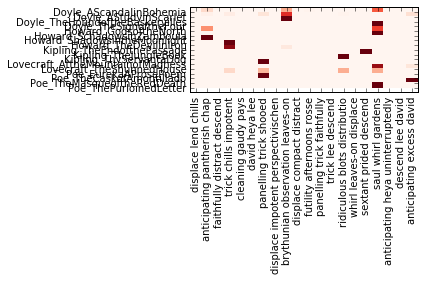

In [29]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

<module 'matplotlib.pyplot' from '/home/sina/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

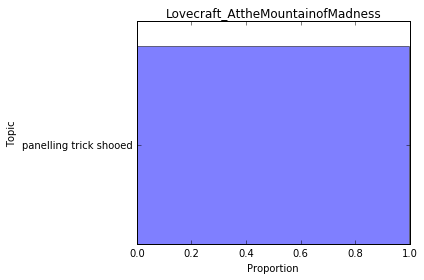

In [30]:
visual.plot_doc_topics(doc_topic, 0)

In [31]:
items = model.show_topic(1)
keywords = [item[0] for item in items]
keywords
items = model.show_topic(1)
propabilities = [item[1] for item in items]
propabilities
items

[('anticipating', 0.0041253618178538594),
 ('pantherish', 0.0040946187241391301),
 ('chap', 0.0038379408079611248),
 ('david', 0.0036847424904771844),
 ('smaller', 0.0035701128464406449),
 ('gipsies', 0.0035674404367478361),
 ('heya', 0.00334244764412604),
 ('monotony', 0.0029577853527693351),
 ('descend', 0.0029556237473556458),
 ('displace', 0.0027345811903157153)]

<module 'matplotlib.pyplot' from '/home/sina/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

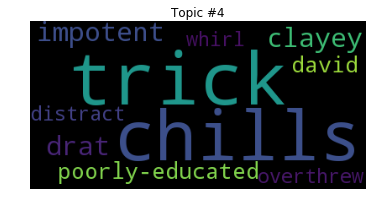

In [32]:
topic_nr = 3
number_of_keywords = 10
visual.show_wordle_for_topic(model, topic_nr, number_of_keywords)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)